In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train.csv']


In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

CPU times: user 2min 22s, sys: 10.6 s, total: 2min 33s
Wall time: 2min 33s


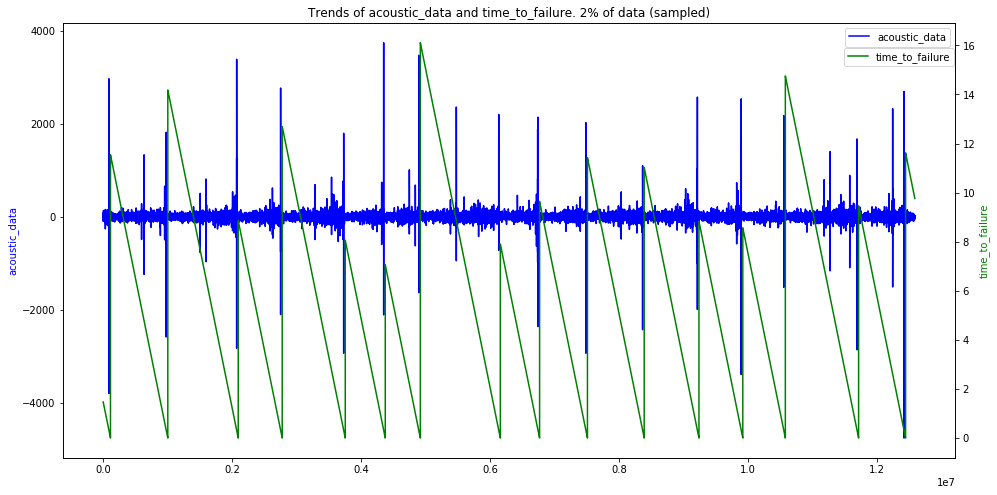

In [3]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

In [4]:
print(train.head())
print(train.shape)



   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
(629145480, 2)


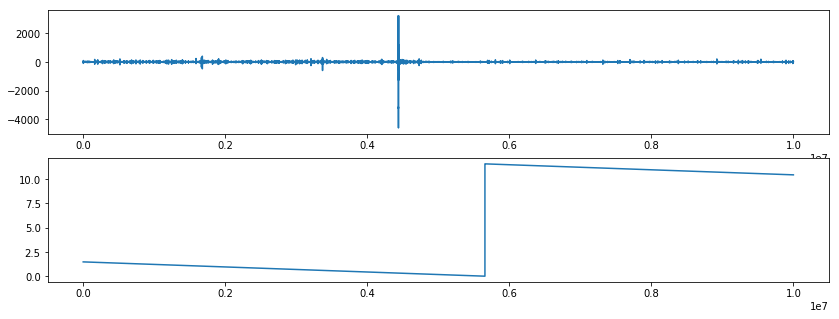

In [5]:
#629.145.480 629 milions rows for easy and fast processing get only first 10.000.000 10 milions rows
small_train=train[0:10000000]
small_train.shape
#plot acustic data secuence first 10 milions rows
fig,ax=plt.subplots(2,1,figsize=(17,17))
small_train['acoustic_data'].plot(figsize=(14,5),ax=ax[0])
small_train['time_to_failure'].plot(figsize=(14,5),ax=ax[1])
#lets try to catch a earthquake moment
#629.145.480 629 milions rows for easy and fast processing get only first 10.000.000 10 milions rows

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Mean time between signals--> -8.943799066027058e-07 MAX time between signals--> 0.0010954966000000094 MIN time between signals--> -11.54000450717705


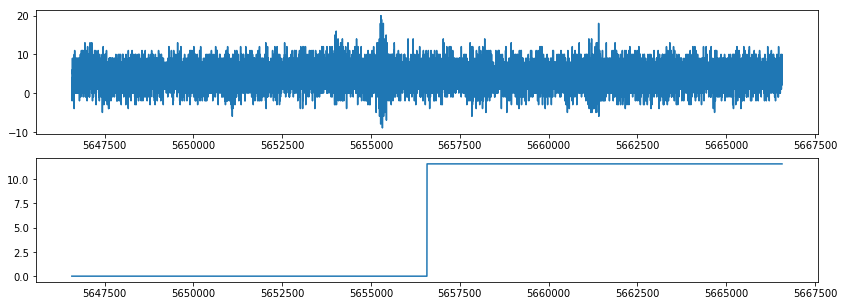

In [6]:
#we whant check few acustic data before and after earthquake
first_quake=small_train[(small_train['time_to_failure']>small_train['time_to_failure'].shift(1))].head().index[0]
catch_train=train[first_quake-10000:first_quake+10000]
catch_train.shape

#plot acustic data secuence first 10 milions rows
fig,ax=plt.subplots(2,1,figsize=(17,17))
catch_train['acoustic_data'].plot(figsize=(14,5),ax=ax[0])
catch_train['time_to_failure'].plot(figsize=(14,5),ax=ax[1])
#calculate time between acustics signals
small_train['time-1'] = small_train['time_to_failure'].shift(-1)
small_train['dif_time'] = small_train['time_to_failure']-small_train['time-1']
print("Mean time between signals-->",small_train['dif_time'].mean(),"MAX time between signals-->",small_train['dif_time'].max(),"MIN time between signals-->",small_train['dif_time'].min())
#small_train['dif_time'].plot(figsize=(14,5))

In [7]:
#we try to do agrupations of N_SIGNALS
Q1 = train['acoustic_data'].quantile(0.25)
Q3 = train['acoustic_data'].quantile(0.75)
IQR = Q3 - Q1

minoutlier=Q1*-1.5*IQR
maxoutlier=Q3*1.5*IQR


In [8]:
minoutlier

-15.0

In [9]:

GROUPS=500

def c_std(series):
    return np.std(series)

windows=[8,13,21,34]
stockD_windows= [5, 8, 13,21]
MACD_FAST=12
MACD_SLOW=26
BOLLINGER_BAND_STD=20
BOLLINGER_BAND_PERIOD=21

def getsample(input_set):
    # recibe a 150.000 acoustic data steps and we group into GROUPS steps
    final_sample=pd.DataFrame(np.array(input_set).reshape((len(input_set),1)),columns=['acoustic_data'])    
    #final_sample[final_sample<minoutlier] = minoutlier
    #final_sample[final_sample>maxoutlier] = maxoutlier
    #final_sample=final_sample+(-1*minoutlier)+1
    final_sample.index = pd.to_datetime(final_sample.index,unit="s")    
    mdata = final_sample.resample(str(GROUPS)+"s").agg(        
         {'acoustic_data' : ['first',max,min,'last']    
        }    
    )
    mdata.columns=mdata.columns.droplevel(0)
    
    # we create new indicators with normalized data
    # mdata=(mdata[windows[-1]:]-minoutlier)/(maxoutlier-minoutlier)
    # mdata=(mdata-minoutlier)/(maxoutlier-minoutlier)
    mdata=(mdata-5)/(3)
    
    # we generate indicatos calculations inside newdata table
    newdata=pd.DataFrame()    
    for window,stockd_win in zip(windows,stockD_windows):
        newdata['mamin{}'.format(window)]=mdata['min'].rolling(window).mean()
        newdata['maopen{}'.format(window)]=mdata['first'].rolling(window).mean()
        newdata['mamax{}'.format(window)]=mdata['max'].rolling(window).mean()        
        newdata['malast{}'.format(window)]=mdata['last'].rolling(window).mean()
        # newdata['stock{}'.format(window)]=(mdata['last']-mdata['min'].rolling(window).min())/(mdata['max'].rolling(window).max()-mdata['min'].rolling(window).min())
        # newdata['stockD{}'.format(window)]=newdata['stock{}'.format(window)].rolling(stockd_win).mean()
        
        
    # newdata['MACD'] = (mdata['last'].rolling(MACD_FAST).mean()-mdata['last'].rolling(MACD_SLOW).mean())
    # newdata['Band'] = mdata['last'].rolling(BOLLINGER_BAND_STD).std()
    # newdata['Uband'] = mdata['last'].rolling(BOLLINGER_BAND_PERIOD).mean() + (newdata['Band']*2)
    # newdata['Lband'] = mdata['last'].rolling(BOLLINGER_BAND_PERIOD).mean() - (newdata['Band']*2)
    # newdata['ema'] = mdata['last'].ewm(com=0.5).mean()
    
    # return newdata and we waranting not NAN related to initial position of indicatos buffers
    # return mdata[~np.isnan(mdata).any(axis=1)]
    return newdata[~np.isnan(newdata).any(axis=1)]
    

In [10]:
randitem=123234
NUM_INPUT_ITEMS=150000
demo=train[randitem:randitem+NUM_INPUT_ITEMS]
#print(demo.head())
final=getsample(demo["acoustic_data"])
print(final)
print(final.shape) #means 48 features
NUM_STEPS=final.shape[0]
FEATURES=final.shape[1]
print(FEATURES)

                       mamin8       maopen8    ...      mamax34  malast34
1970-01-01 04:35:00 -4.083333 -3.750000e-01    ...     3.147059 -0.107843
1970-01-01 04:43:20 -3.833333 -5.833333e-01    ...     3.068627 -0.058824
1970-01-01 04:51:40 -3.625000 -5.416667e-01    ...     3.019608 -0.058824
1970-01-01 05:00:00 -3.833333 -3.333333e-01    ...     3.117647 -0.039216
1970-01-01 05:08:20 -3.666667 -8.333333e-02    ...     3.088235 -0.049020
1970-01-01 05:16:40 -3.625000 -3.333333e-01    ...     3.156863 -0.068627
1970-01-01 05:25:00 -3.875000 -2.083333e-01    ...     3.225490 -0.039216
1970-01-01 05:33:20 -4.375000 -2.083333e-01    ...     3.362745  0.019608
1970-01-01 05:41:40 -4.875000 -1.666667e-01    ...     3.431373 -0.068627
1970-01-01 05:50:00 -5.250000 -2.500000e-01    ...     3.529412 -0.098039
1970-01-01 05:58:20 -5.250000 -8.333333e-02    ...     3.529412 -0.088235
1970-01-01 06:06:40 -4.833333 -1.666667e-01    ...     3.529412 -0.049020
1970-01-01 06:15:00 -4.791667 -2.50000

In [11]:
NUM_INPUT_ITEMS=150000
MAX_ITEM=train.shape[0]-NUM_INPUT_ITEMS
BATCH_SIZE=8

def generator():
    while True:
        X_train=np.zeros((BATCH_SIZE,NUM_STEPS,FEATURES))
        y_train=np.zeros((BATCH_SIZE,1))
        for x in range(BATCH_SIZE):            
            while True:
                start=np.random.randint(0,MAX_ITEM)
                pd_sample=train[start:start+NUM_INPUT_ITEMS]      
                #print(pd_sample.shape)
                npdata=np.array(getsample(pd_sample["acoustic_data"]))     
                if npdata.shape[0]>=NUM_STEPS:
                    break                      
            npdata=npdata.reshape(NUM_STEPS,FEATURES)                    
            y_train[x]=(((pd_sample.values[NUM_INPUT_ITEMS-1,1])/16)-0).clip(0,1)            
            X_train[x]=npdata
        yield X_train,y_train
# check how look our batch training data        
X,y=next(generator())    
print(X.shape)
print(X)
print(y)


(8, 267, 16)
[[[-4.00000000e+00 -3.75000000e-01  2.87500000e+00 ... -2.15686275e-01
    3.12745098e+00 -2.45098039e-01]
  [-3.79166667e+00 -3.33333333e-01  2.66666667e+00 ... -2.64705882e-01
    3.10784314e+00 -2.54901961e-01]
  [-3.25000000e+00 -4.58333333e-01  2.54166667e+00 ... -2.25490196e-01
    3.09803922e+00 -2.54901961e-01]
  ...
  [-4.58333333e+00 -6.25000000e-01  3.70833333e+00 ... -6.86274510e-02
    3.33333333e+00  9.80392157e-02]
  [-4.50000000e+00 -3.75000000e-01  3.79166667e+00 ... -9.80392157e-03
    3.24509804e+00 -9.80392157e-03]
  [-3.87500000e+00 -5.00000000e-01  3.54166667e+00 ... -2.94117647e-02
    3.23529412e+00  1.96078431e-02]]

 [[-4.00000000e+00 -1.04166667e+00  3.33333333e+00 ... -7.64705882e-01
    4.17647059e+00 -5.09803922e-01]
  [-4.04166667e+00 -7.91666667e-01  3.41666667e+00 ... -7.45098039e-01
    4.20588235e+00 -5.00000000e-01]
  [-4.04166667e+00 -2.91666667e-01  3.37500000e+00 ... -6.76470588e-01
    4.20588235e+00 -4.41176471e-01]
  ...
  [-8.0000

In [ ]:
# Define model
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
def root_mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)+0.0000001)
def cust_maex(y_true, y_pred):
    return K.mean(K.abs((K.exp(y_pred) - K.exp(y_true))), axis=-1)+0.0000001

def cust_maev2(y_true, y_pred):
    return K.mean(K.abs((((y_pred)*16) - ((y_true)*16))), axis=-1)+0.0000001

def cust_mae(y_true, y_pred):
    return K.mean(K.abs(((((y_pred)*8)+1) - (((y_true)*8)+1))), axis=-1)+0.0000001

In [ ]:
checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')

model = Sequential()
model.add(LSTM(256, input_shape=(NUM_STEPS, FEATURES)))

#model.add(Dense(10, activation='relu'))
#model.add((LSTM(48, return_sequences=False,input_shape=(NUM_STEPS, FEATURES))))
#model.add((LSTM(15, return_sequences=True)))
#model.add((LSTM(15, return_sequences=True)))
#model.add((LSTM(15, return_sequences=False)))
# we can think of this chunk as the hidden layer    
model.add(Dense(64, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
#model.add(Dropout(0.25))
# we can think of this chunk as the hidden layer    
model.add(Dense(64, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
#model.add(Dropout(0.25))
# we can think of this chunk as the hidden layer    
model.add(Dense(64, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
#model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('tanh'))

# Compile and fit model
model.compile(loss="mae", optimizer='adam', metrics=['mae',cust_mae,cust_maev3])
model.summary()

In [ ]:
model2 = Sequential()
model2.add(LSTM(input_shape = (NUM_STEPS, FEATURES), 
               units = NUM_STEPS, 
               return_sequences = True))
#model2.add(Dropout(0.5))
model2.add(LSTM(256))
#model2.add(Dropout(0.5))
model2.add(Dense(64, activation="relu"))
model2.add(Dense(1))
model2.add(Activation("tanh"))
model2.compile(loss = "mae", 
              optimizer = "adam",
              metrics=[cust_mae])
model2.summary()

In [ ]:
model2 = Sequential()
model2.add(CuDNNGRU(NUM_STEPS, input_shape=(NUM_STEPS, FEATURES)))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss = "mae", 
              optimizer = "adam",
              metrics=[cust_maev2])

model2.summary()

In [ ]:
checkpoint = ModelCheckpoint('model2.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')
BATCH_SIZE=32

model2.fit_generator(generator(),
                              steps_per_epoch=100,
                              epochs=20,
                              verbose=1,
                              callbacks=[checkpoint])